# Evaluate models trained in other notebook:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 32.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 48.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 38.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.4 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516317 sha256=d553fe4498c60a16f089074c8d1fab89975dd98c098717f7a23bdffa764c2b0a
  Stored in directory: /root/.cache/pip/whee

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files
import math

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
print(torch.__version__)

1.11.0+cu113


### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.3


### Helper scripts:

In [5]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [6]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:

In [7]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

## Load data:

### (Input eval 1) Global climate model (GCM Like):

In [8]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    linkGCMLike = 'https://drive.google.com/file/d/1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo/view?usp=sharing'
    idGCMLike = '1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo'
    downloaded = Googledrive.CreateFile({'id':idGCMLike}) 
    downloaded.GetContentFile(fileGCMLike)  
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)

CPU times: user 2.37 s, sys: 569 ms, total: 2.94 s
Wall time: 8.33 s


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

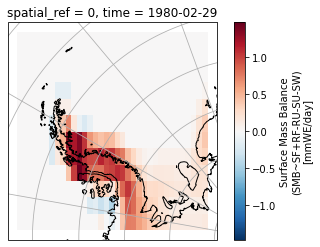

In [9]:
ds = createLowerInput(GCMLike, region='Larsen', Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)
ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo() )
ds.SMB.isel(time = 1).plot(x='x', ax = ax, transform=ccrs.SouthPolarStereo())
ax.coastlines("10m", color="black")
ax.gridlines()

### (Input eval 2) Real GCM:

In [10]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCM)
    GCMLike = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
else:
    idGCM = '1kAJPKhgQ3pMAgeOaQ5nzllCO-rF9kXIO'
    downloaded = Googledrive.CreateFile({'id':idGCM}) 
    downloaded.GetContentFile(fileGCM)  
    GCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
GCM = GCM.rename_vars({'psl':'SP', 'uas':'VVP', 'vas':'UUP', 'pr':'RF', 'rlut': 'LWD', 'tas': 'TT', 'rsut':'SWD'})

CPU times: user 1.6 s, sys: 200 ms, total: 1.8 s
Wall time: 8.86 s


In [11]:
GCM

<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    SP           (time, y, x) float32 ...
    VVP          (time, y, x) float32 ...
    RF           (time, y, x) float64 ...
    LWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    UUP          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
Attributes: (12/29)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413
    crs:                    3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


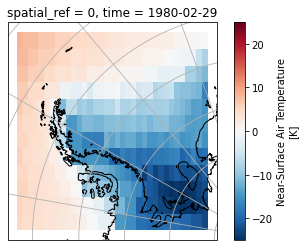

In [12]:
ds = createLowerInput(GCM, region='Larsen', Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)
ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo() )
ds.TT.isel(time = 1).plot(x='x', ax = ax, transform=ccrs.SouthPolarStereo())
ax.coastlines("10m", color="black")
ax.gridlines()

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

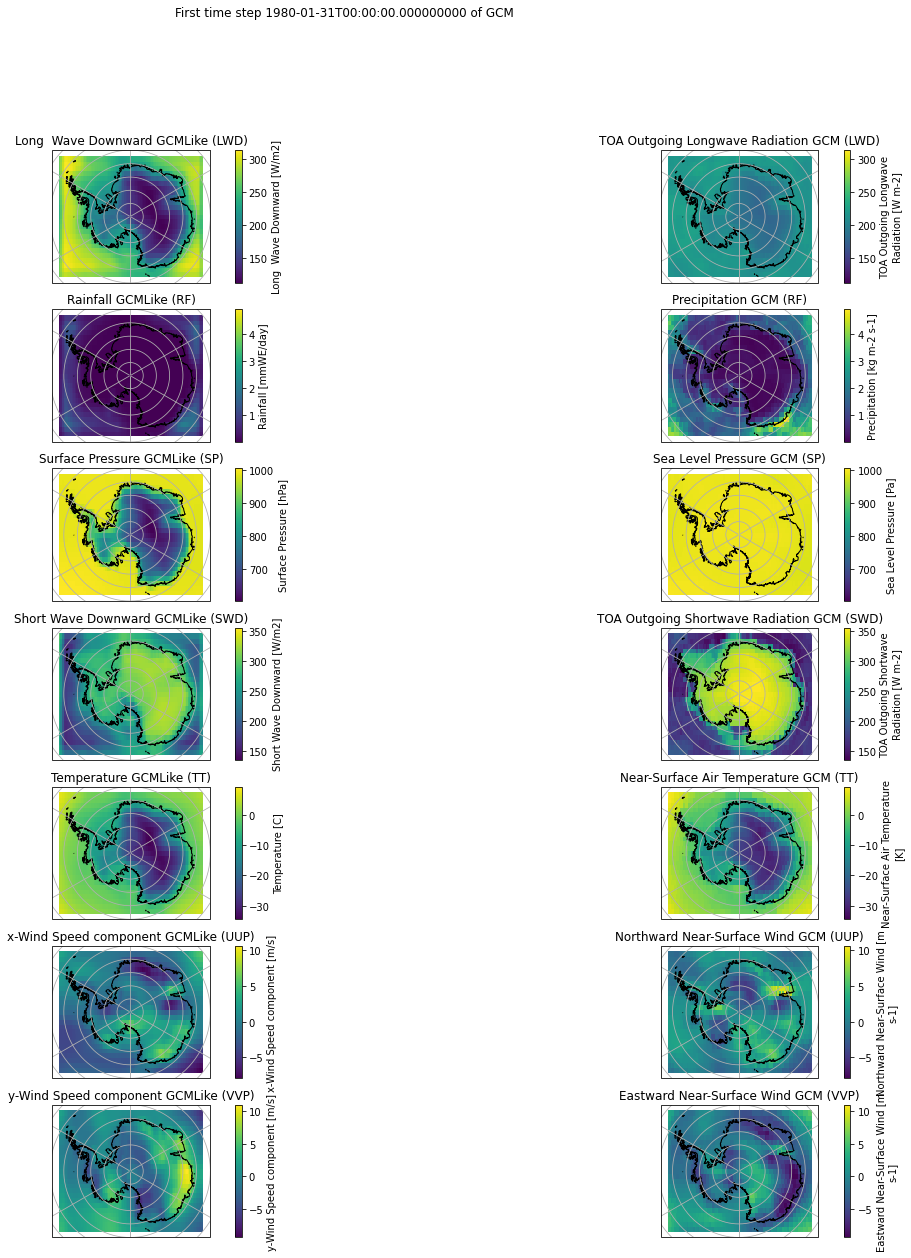

In [13]:
plotAllVar2Xr(
    GCMLike.drop(['SMB']),  # xr.Dataset
    GCM
)

### (Target) Regional climate model:

In [14]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
    downloaded = Googledrive.CreateFile({'id':idTarget}) 
    downloaded.GetContentFile(fileTarget) 
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7})
CPU times: user 27.6 s, sys: 7.78 s, total: 35.4 s
Wall time: 1min 54s


In [15]:
target_dataset

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 160, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SP           (time, y, x) float32 999.8 999.6 999.5 ... 985.7 985.9 986.2
    LWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TT           (time, y, x) float32 5.735 5.514 5.299 ... 3.045 3.182 3.328
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVP          (time, y, x) float64 6.066 5.686 5.358 ... -5.0 -5.258 -5.475
    UUP          (time, y, x) float64 -2.094 -1.85 -1.73 ... 4.135 4.28 4.378
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:47:19 2022: ncap2 -O -s RF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

### Interpolated SMB: (easy model)

Frozen({'time': 1452, 'y': 148, 'x': 176})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160})
CPU times: user 1.39 s, sys: 396 ms, total: 1.79 s
Wall time: 3.28 s


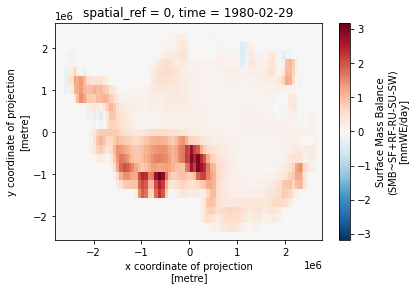

In [16]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    interp_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    linkTarget = 'https://drive.google.com/file/d/1ASmD2JuIjCK1DY6Lon2eBhH8X1NWFuR0/view?usp=sharing'
    idTarget = '1ASmD2JuIjCK1DY6Lon2eBhH8X1NWFuR0'
    downloaded = Googledrive.CreateFile({'id':idTarget})
    nameInt = 'MAR(ACCESS1-3)-stereographic_monthly_interpolated_SMB.nc' 
    downloaded.GetContentFile(nameInt) 
    interp_dataset = xr.open_dataset(nameInt)
    os.remove(nameInt)
print(interp_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

interp_dataset = cutBoundaries(interp_dataset, max_x, max_y)
print("New target dimensions:", interp_dataset.dims)
interp_dataset
interp_dataset.isel(time = 1).SMB.plot(x='x')

# Scenario 1: evaluation on RCM

## Larsen:

In [17]:
from dataFunctions import *
from makeInputs import *
from config import *
from training import *
from metrics import *
from prediction import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Larsen - Attention - NRMSE:

Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike


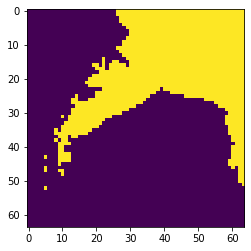

In [38]:
REGION = "Larsen"
LOSS_ = "NRMSE"
TYPENET = "Attention"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike = GCMLike, GCM = GCM, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION,
    dropvar = None
)

i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike = GCMLike, GCM = None, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION,
    dropvar = None
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]

full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

In [39]:
"""
fig = plt.figure(figsize=(10, 20))

m = 1
for i in range(len(VAR_LIST)):
  ax = plt.subplot(5,2,m)
  n, bins, patches = ax.hist(full_input_GCM[0][0,:,:,i], 50)
  ax.set_title(f'GCM {VAR_LIST[i]} ')
  m+=1
  ax2 = plt.subplot(5,2,m)
  n, bins, patches = ax2.hist(full_input[0][0,:,:,i], 50)
  ax2.set_title(f'GCM Like {VAR_LIST[i]}')
  m+=1"""

"\nfig = plt.figure(figsize=(10, 20))\n\nm = 1\nfor i in range(len(VAR_LIST)):\n  ax = plt.subplot(5,2,m)\n  n, bins, patches = ax.hist(full_input_GCM[0][0,:,:,i], 50)\n  ax.set_title(f'GCM {VAR_LIST[i]} ')\n  m+=1\n  ax2 = plt.subplot(5,2,m)\n  n, bins, patches = ax2.hist(full_input[0][0,:,:,i], 50)\n  ax2.set_title(f'GCM Like {VAR_LIST[i]}')\n  m+=1"

In [40]:
# Parameters used in training
TYPENET = "Attention"

trainingParam = dict(
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    seed=SEED,
    amp=AMP,
    test_percent=TEST_PERCENT,
    val_percent=VAL_PERCENT,
    loss_=LOSS_,
    typeNet=TYPENET,
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    mask,
    region=REGION,
    train=False,
    randomSplit=False,
    **trainingParam,
)

# Load saved model
today = str(date.today())
# today = '2022-05-13'

model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}.pth"
downloadModel = True
if downloadModel:
    # downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    if TYPENET == "Attention":
        print("Loading from attention model")
        #bestModelId = "1-XnM-cYK4xi7ozjSDggJNtl5egbc-IiY" # best model
        #idModel = '1-ulYWFvvScuxhonb9pT637uAsqIzkpff'
        idModel = '1rgSGIdbdLSORRXWYcF4VWEloET9dLNPK'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
(preds_Larsen_NRMSE,
    x_Larsen_NRMSE,
    z_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    r_Larsen_NRMSE,
) = predict(net, device, test_set, model)

INFO: Using device cpu
INFO: Attention SmAt_UNet model
INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 7, 32, 32])
Loading from attention model


INFO: Loading saved model MODEL_2022-05-29_Larsen_100_32_Attention_NRMSE.pth
INFO: Using device cpu
INFO: Saved model loaded!


#### Points and timeseries:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


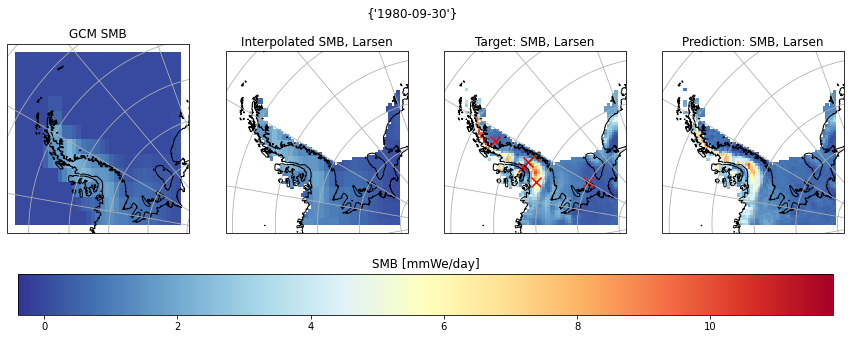

In [41]:
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 29, "y": 24},
    {"x": 31, "y": 26},
    {"x": 32, "y": 16},
    {"x": 52, "y": 16},
)

plotRandomPrediction(
    preds_Larsen_NRMSE,
    x_Larsen_NRMSE,
    z_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    r_Larsen_NRMSE,
    GCMLike,
    interp_dataset,
    VAR_LIST,
    target_dataset,
    points_RCM,
    regions=[REGION],
)

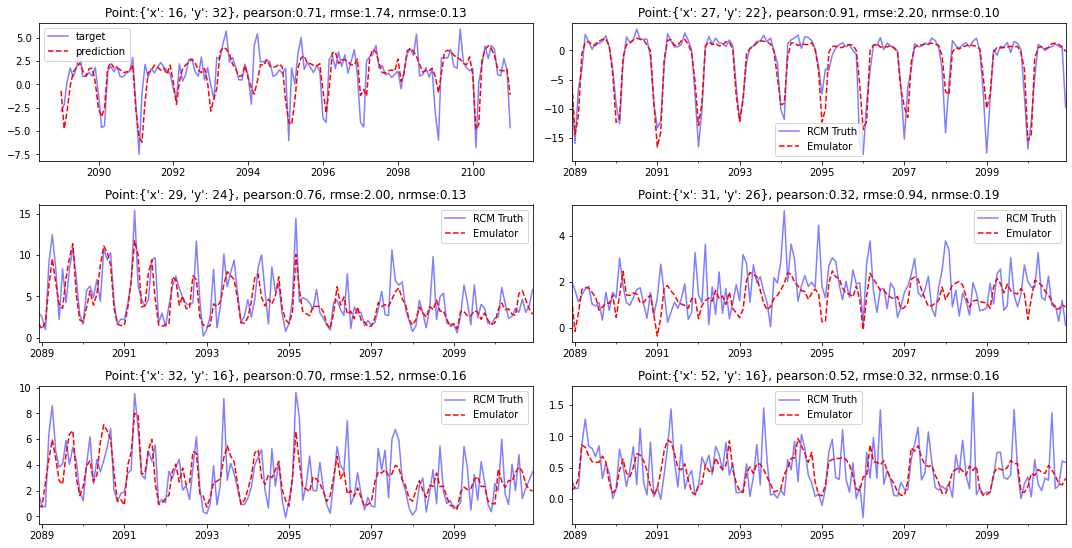

In [42]:
plotTimeseries(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    train_set,
    target_dataset,
    points_RCM,
    REGION,
    len(points_RCM),
)

#### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Text(0.5, 0.98, 'Emualtor')

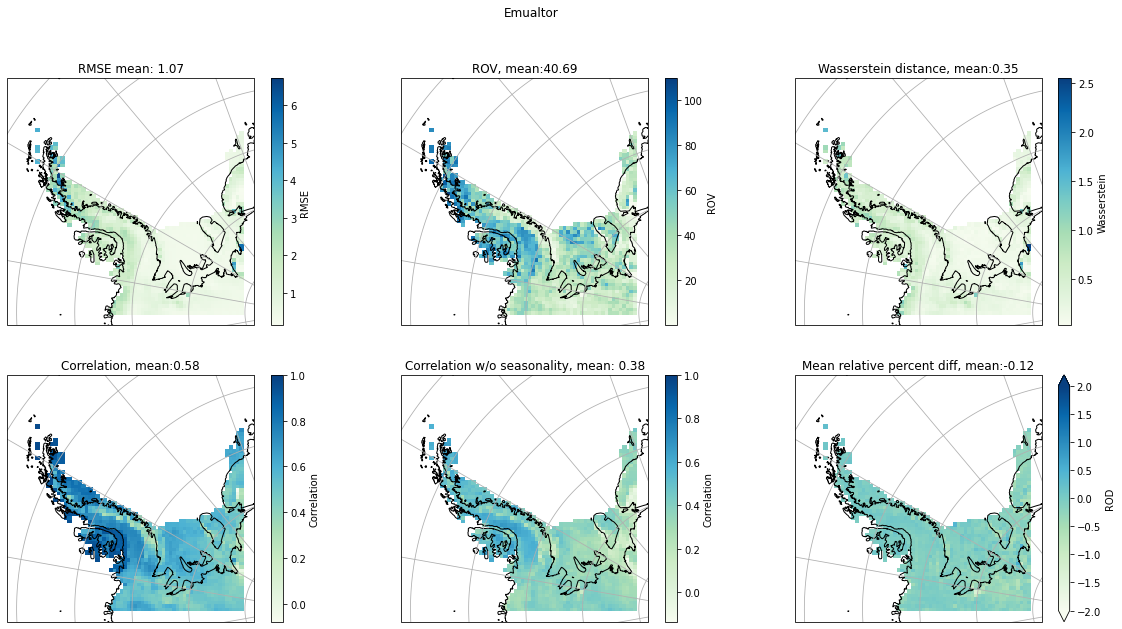

In [43]:
ignoreSea = True
PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    PearsonCorrAn,
    ROD,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)
plt.suptitle("Emualtor")

In [25]:
"""
ignoreSea = True
dsRCM = createLowerTarget(
				interp_dataset, region=REGION, Nx=64, Ny=64, print_=False
			)
predInt = np.expand_dims(dsRCM.SMB.values[len(train_set):],3)
PearsonCorr, Wasserstein, ROV, RMSE, NRMSE, PearsonCorrAn = calculateMetrics(
    predInt, true_smb_Larsen_NRMSE, target_dataset, train_set, REGION, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    NRMSE,
    PearsonCorrAn,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)
plt.suptitle('Basic interpolation')"""

'\nignoreSea = True\ndsRCM = createLowerTarget(\n\t\t\t\tinterp_dataset, region=REGION, Nx=64, Ny=64, print_=False\n\t\t\t)\npredInt = np.expand_dims(dsRCM.SMB.values[len(train_set):],3)\nPearsonCorr, Wasserstein, ROV, RMSE, NRMSE, PearsonCorrAn = calculateMetrics(\n    predInt, true_smb_Larsen_NRMSE, target_dataset, train_set, REGION, ignoreSea\n)\nplotMetrics(\n    PearsonCorr,\n    Wasserstein,\n    ROV,\n    NRMSE,\n    PearsonCorrAn,\n    target_dataset,\n    REGION,\n    today,\n    trainingParam["num_epochs"],\n    trainingParam["batch_size"],\n)\nplt.suptitle(\'Basic interpolation\')'

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


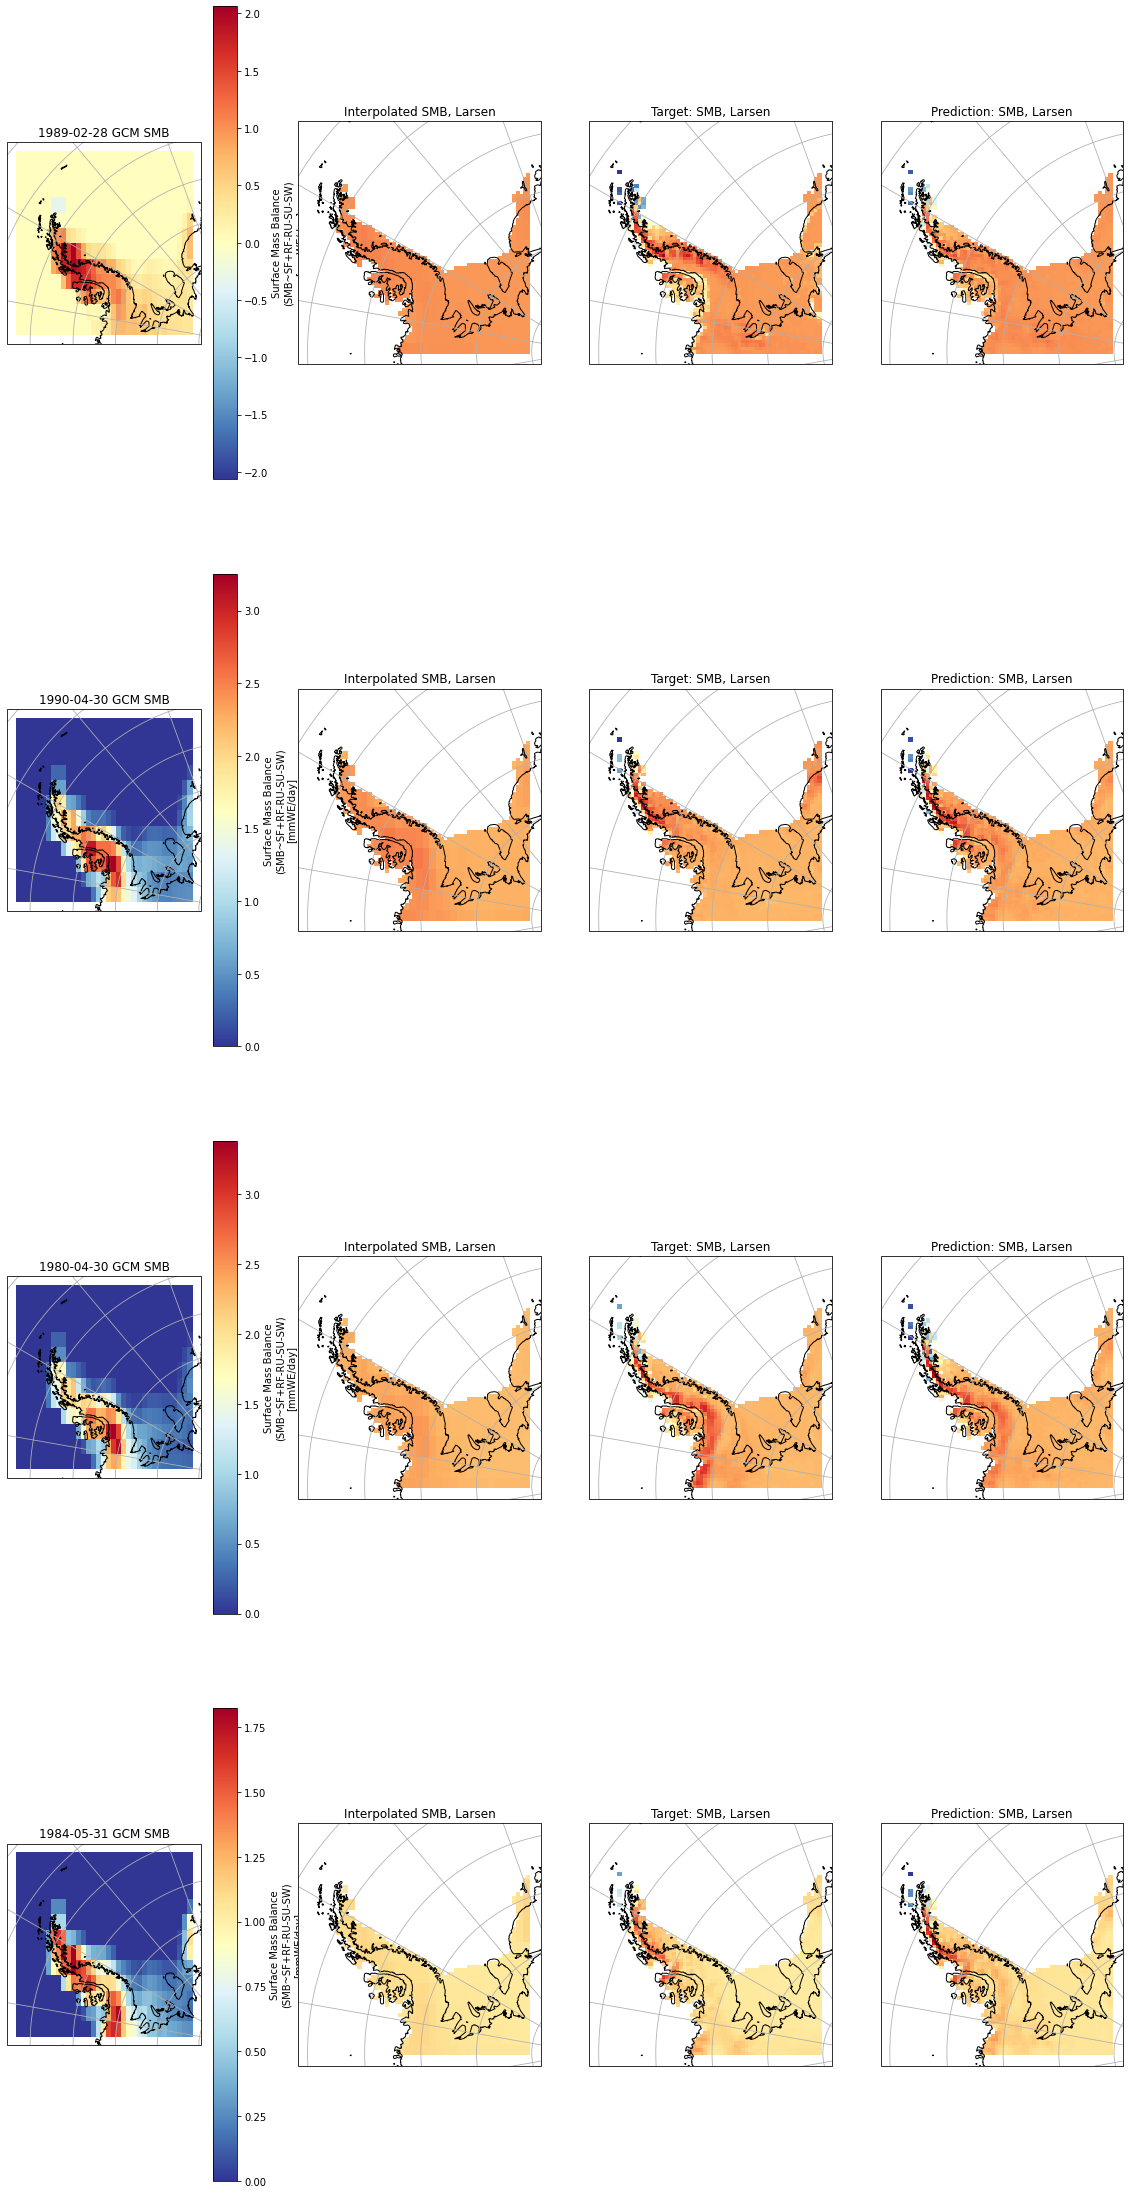

In [44]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Larsen_NRMSE,
    x_Larsen_NRMSE,
    z_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    r_Larsen_NRMSE,
    GCMLike,
    interp_dataset,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
)
nameFig = "{}_pred_{}_{}_{}.png".format(
    today, REGION, trainingParam["num_epochs"], trainingParam["batch_size"]
)
plt.savefig(nameFig)
# files.download(nameFig)

#### Ridge:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


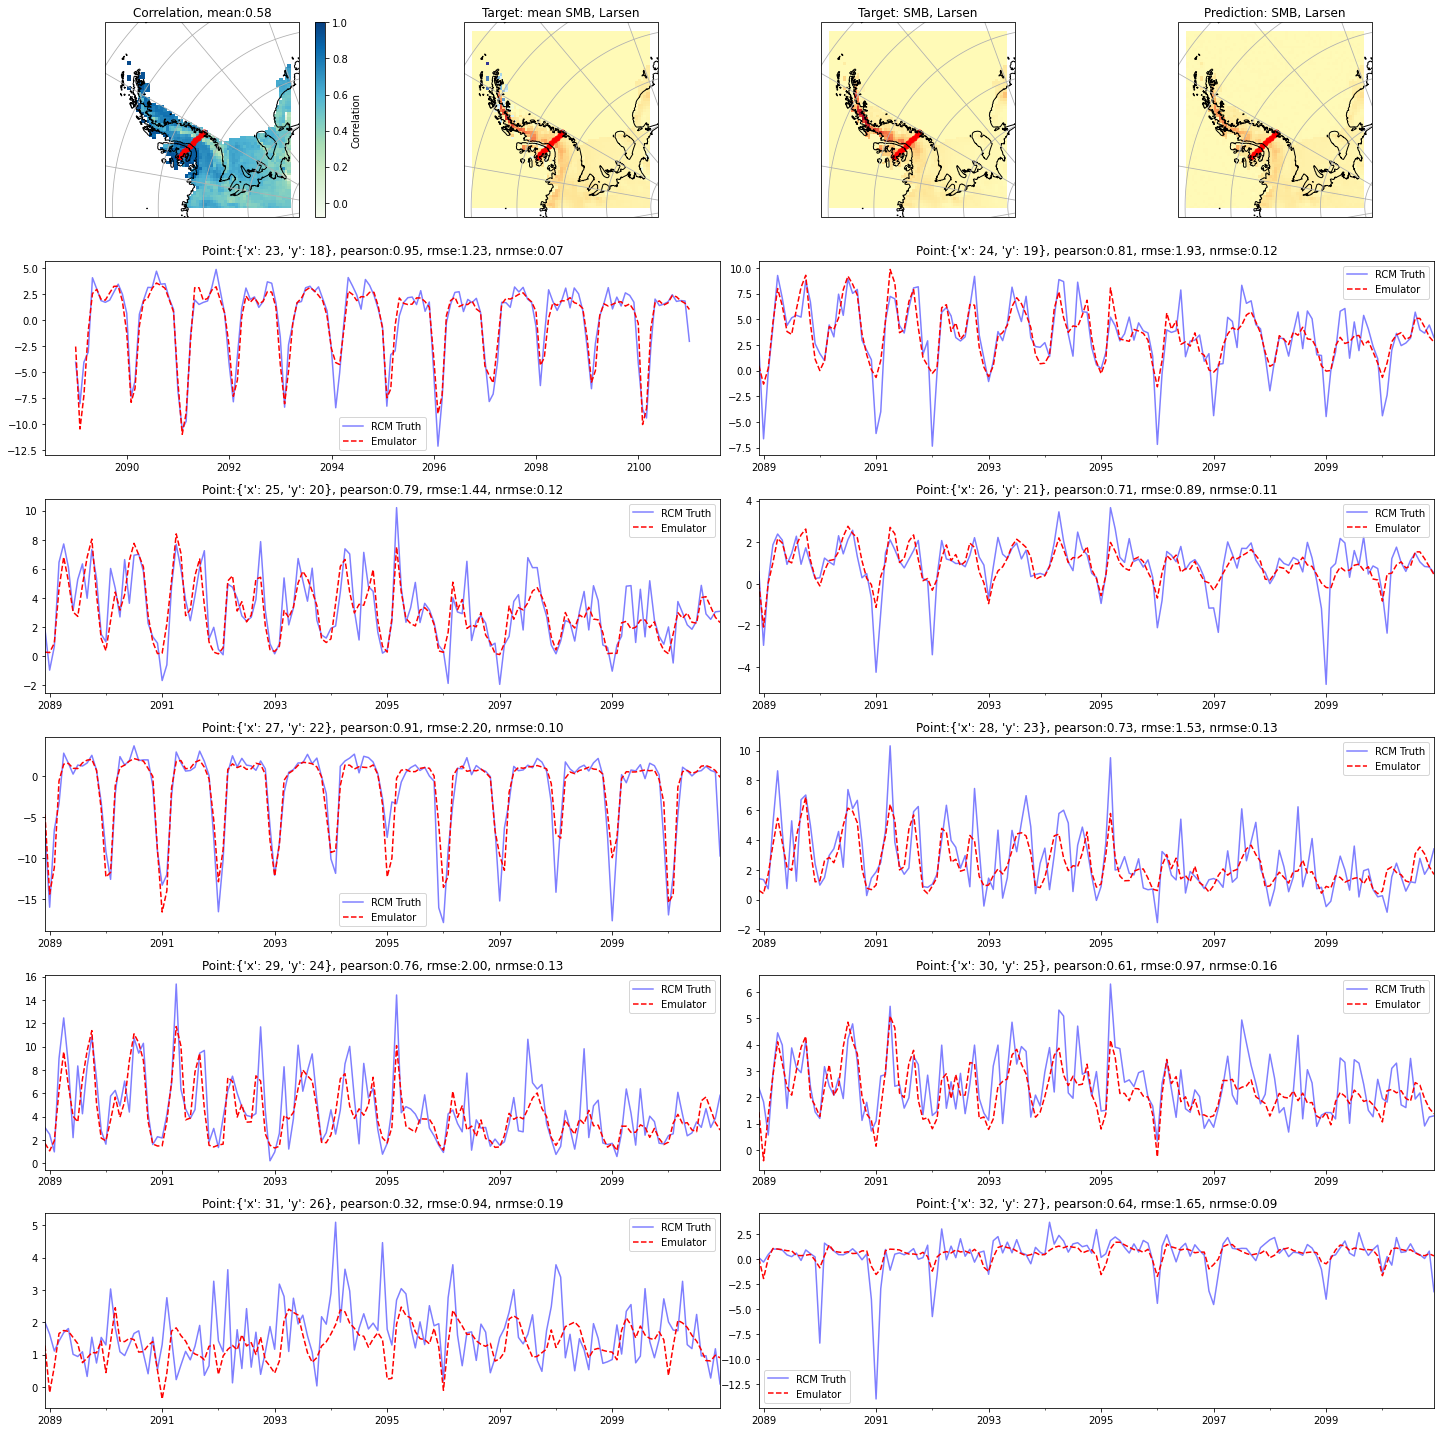

In [45]:
from metrics import *
# plot points
coordinates = (
    {"x": 23, "y": 18},
    {"x": 24, "y": 19},
    {"x": 25, "y": 20},
    {"x": 26, "y": 21},
    {"x": 27, "y": 22},
    {"x": 28, "y": 23},
    {"x": 29, "y": 24},
    {"x": 30, "y": 25},
    {"x": 31, "y": 26},
    {"x": 32, "y": 27}
)

randomPoints(
    coordinates,
    PearsonCorr,
    true_smb_Larsen_NRMSE,
    preds_Larsen_NRMSE,
    target_dataset,
    GCMLike,
    train_set,
    REGION,
    N = len(coordinates),
    marker = '.',
    figsize = (20, 20),
)
nameFig = "{}_ts_{}_{}_{}_{}.png".format(
    today, REGION, LOSS_, trainingParam["num_epochs"], trainingParam["batch_size"]
)
#plt.suptitle('Three time series at diffrent coordinates, loss: MSE')
plt.suptitle('')
plt.savefig(nameFig)

#### Time series of GCM:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

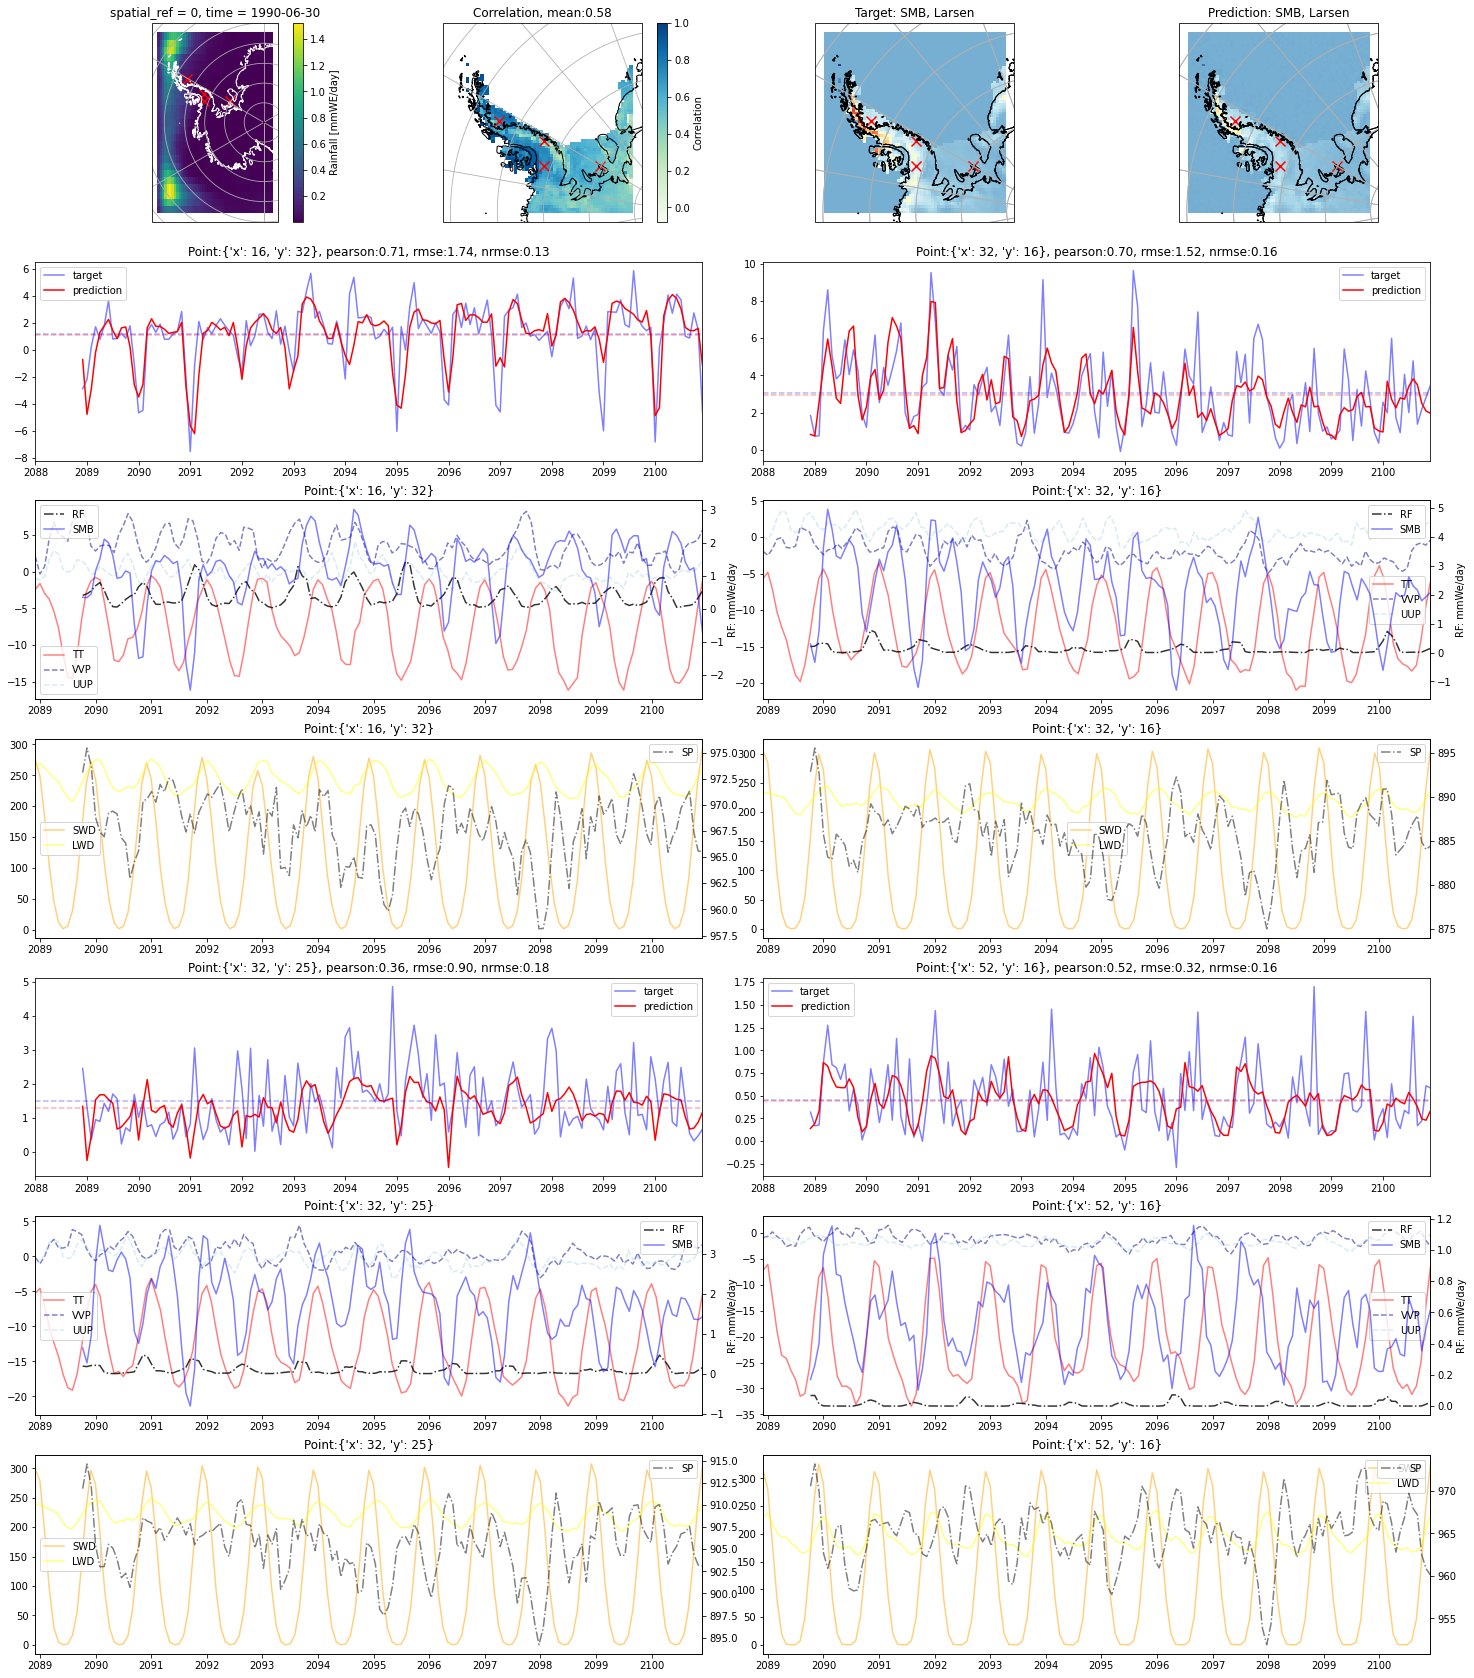

In [46]:
from metrics import *

points_GCM = (
    {"x": 12, "y": 18},
    {"x": 19, "y": 15},
    {"x": 19, "y": 16},
    {"x": 30, "y": 15},
)
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 32, "y": 16},
    {"x": 32, "y": 25},
    {"x": 52, "y": 16},
)
plotGCMTimeseries(
    true_smb_Larsen_NRMSE,
    preds_Larsen_NRMSE,
    GCMLike,
    PearsonCorr,
    target_dataset,
    train_set,
    points_GCM,
    points_RCM,
    REGION,
)

#### Hovmöller plot: 
space versus time, through mountain ridge of Larsen. x: distance, y: time and plot values

[Text(0, 0, '2089-04-30T00:00:00.000000000'),
 Text(0, 0, '2089-12-31T00:00:00.000000000'),
 Text(0, 0, '2090-08-31T00:00:00.000000000'),
 Text(0, 0, '2091-04-30T00:00:00.000000000'),
 Text(0, 0, '2091-12-31T00:00:00.000000000'),
 Text(0, 0, '2092-08-31T00:00:00.000000000'),
 Text(0, 0, '2093-04-30T00:00:00.000000000'),
 Text(0, 0, '2093-12-31T00:00:00.000000000'),
 Text(0, 0, '2094-08-31T00:00:00.000000000'),
 Text(0, 0, '2095-04-30T00:00:00.000000000'),
 Text(0, 0, '2095-12-31T00:00:00.000000000'),
 Text(0, 0, '2096-08-31T00:00:00.000000000'),
 Text(0, 0, '2097-04-30T00:00:00.000000000'),
 Text(0, 0, '2097-12-31T00:00:00.000000000'),
 Text(0, 0, '2098-08-31T00:00:00.000000000'),
 Text(0, 0, '2099-04-30T00:00:00.000000000'),
 Text(0, 0, '2099-12-31T00:00:00.000000000'),
 Text(0, 0, '2100-08-31T00:00:00.000000000')]

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


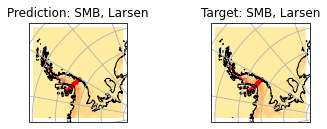

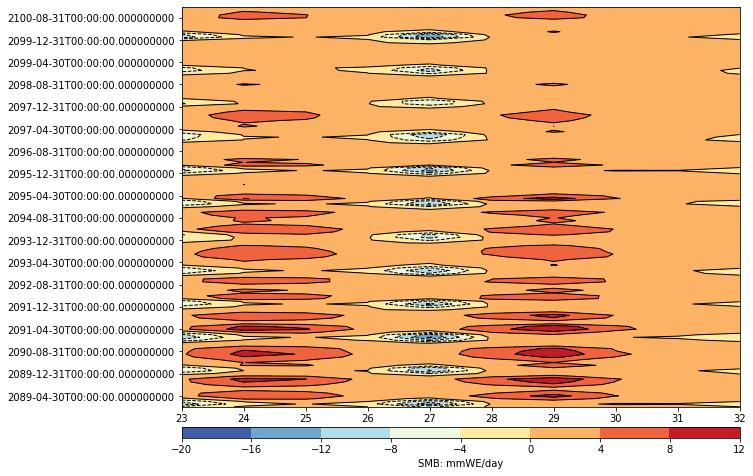

In [29]:
 ax1 = plt.subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax2 = plt.subplot(2,2,2, projection=ccrs.SouthPolarStereo())

ds = createLowerTarget(target_dataset, region=REGION, Nx=64, Ny=64, print_=False)
    
meanPred = np.nanmean(np.array(preds_Larsen_NRMSE), axis = 0)
meanTarget = np.nanmean(np.array(true_smb_Larsen_NRMSE), axis = 0)

vmin = np.min([meanTarget, meanPred])
vmax = np.max([meanTarget, meanPred])
plotPred(target_dataset, meanPred, ax1, vmin, vmax, region=REGION)
plotTarget(target_dataset, meanTarget, ax2, vmin, vmax, region=REGION)

for ax in [ax1,ax2]:
        for p in coordinates:
            ax.scatter(
                ds.isel(x=p["x"]).x.values,
                ds.isel(y=p["y"]).y.values,
                marker=".",
                s=50,
                color="red",
            )
array = np.empty((len(coordinates),len(preds_Larsen_NRMSE)))
for i in range(len(coordinates)):
  p = coordinates[i]
  array[i,:] = np.array(preds_Larsen_NRMSE)[:, p["y"], p["x"], 0]

times = target_dataset.time.values[len(train_set) :]
x = [p['x'] for p in coordinates]

fig = plt.figure(figsize=(10, 20))

df = pd.DataFrame(index = times, data = array.transpose())
ax3 = plt.subplot(2,2,(3,4))
cf = ax3.contourf(x, times, array.transpose(), cmap='RdYlBu_r')
cs = ax3.contour(x, times, array.transpose(), colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('SMB: mmWE/day')

# Make some ticks and tick labels
#ax.set_xticks([0, 90, 180, 270, 357.5])
ax.set_xticklabels('x coordinate')
ax3.set_yticks(times[4::8])
ax3.set_yticklabels(times[4::8])

#cf = ax2.contourf(lons, vtimes, mpcalc.smooth_n_point(avg_data, 9, 2), clevs, cmap=plt.cm.bwr, extend='both')

### Larsen - Baseline - MSE:

Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike


INFO: Using device cpu
INFO: Baseline model
INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 7, 32, 32])


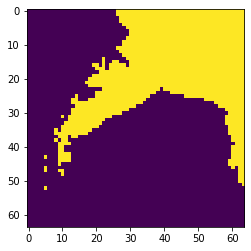

In [30]:
from prediction import *
REGION = "Larsen"
TYPENET = "Baseline"
LOSS_ = "MSE"

# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, GCM=None, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION, dropvar=None
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]
mask = createMask(full_target[0, :, :], onechannel=True)
plt.imshow(mask)
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    seed=SEED,
    amp=AMP,
    test_percent=TEST_PERCENT,
    val_percent=VAL_PERCENT,
    loss_=LOSS_,
    typeNet=TYPENET,
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    mask,
    region=REGION,
    train=False,
    randomSplit=False,
    **trainingParam,
)

In [31]:
# Load saved model
today = str(date.today())
# today = '2022-05-13'

model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}.pth"
downloadModel = True
if downloadModel:
    if TYPENET == "Baseline":
        if LOSS_ == "MSE":
            print("Loading from baseline model")
            idModel = "1ZC6IfH5c5QbbWN1jhmK5j5kh-Y3wqhPT"
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
(preds_Larsen_MSE,
    x_Larsen_MSE,
    z_Larsen_MSE,
    true_smb_Larsen_MSE,
    r_Larsen_MSE,
) = predict(net, device, test_set, model)

Loading from baseline model


INFO: Loading saved model MODEL_2022-05-29_Larsen_100_32_Baseline_MSE.pth
INFO: Using device cpu
INFO: Saved model loaded!


#### Points and timeseries:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


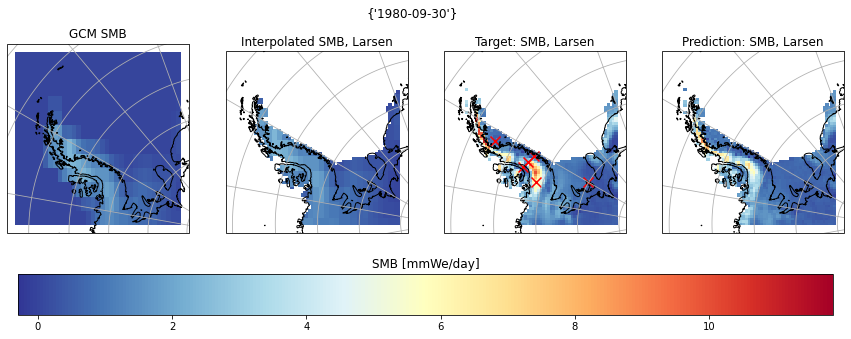

In [32]:
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 29, "y": 24},
    {"x": 31, "y": 26},
    {"x": 32, "y": 16},
    {"x": 52, "y": 16},
)

plotRandomPrediction(
    preds_Larsen_MSE,
    x_Larsen_MSE,
    z_Larsen_MSE,
    true_smb_Larsen_MSE,
    r_Larsen_MSE,
    GCMLike,
    interp_dataset,
    VAR_LIST,
    target_dataset,
    points_RCM,
    regions=[REGION],
)

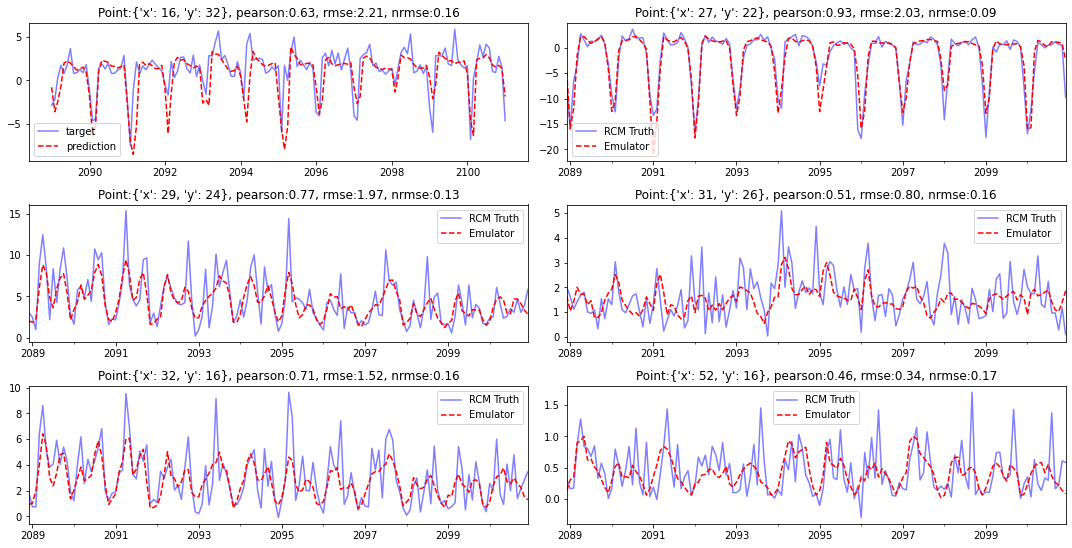

In [33]:
plotTimeseries(
    preds_Larsen_MSE,
    true_smb_Larsen_MSE,
    train_set,
    target_dataset,
    points_RCM,
    REGION,
    len(points_RCM),
)

#### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Text(0.5, 0.98, 'Emualtor')

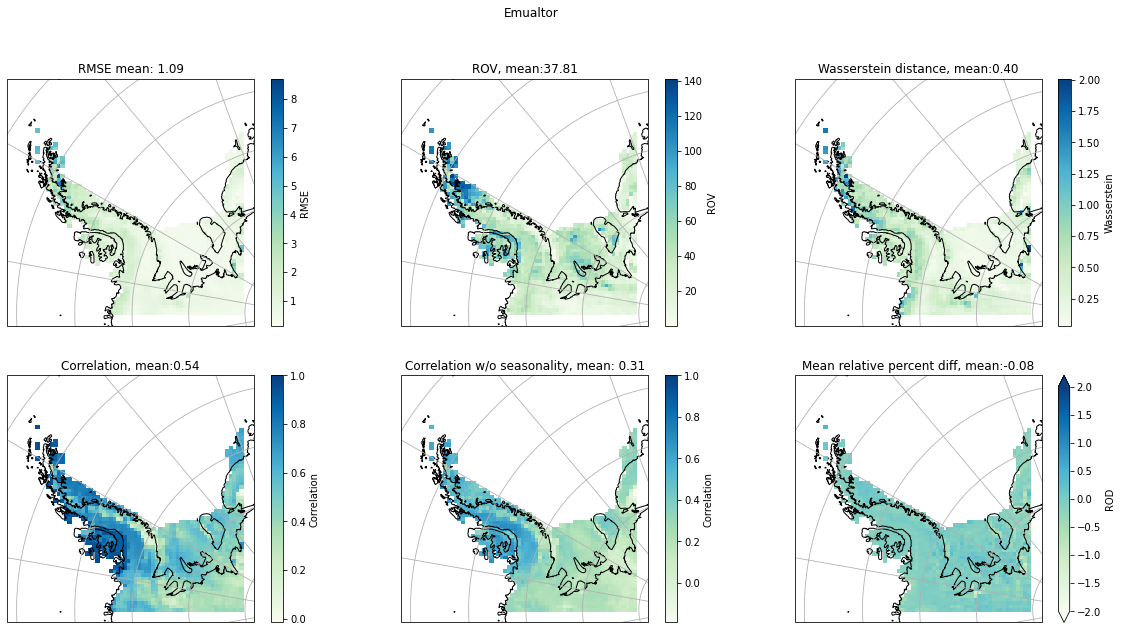

In [34]:
ignoreSea = True
PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
    preds_Larsen_MSE,
    true_smb_Larsen_MSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    PearsonCorrAn,
    ROD,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)
plt.suptitle("Emualtor")

#### Predictions:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


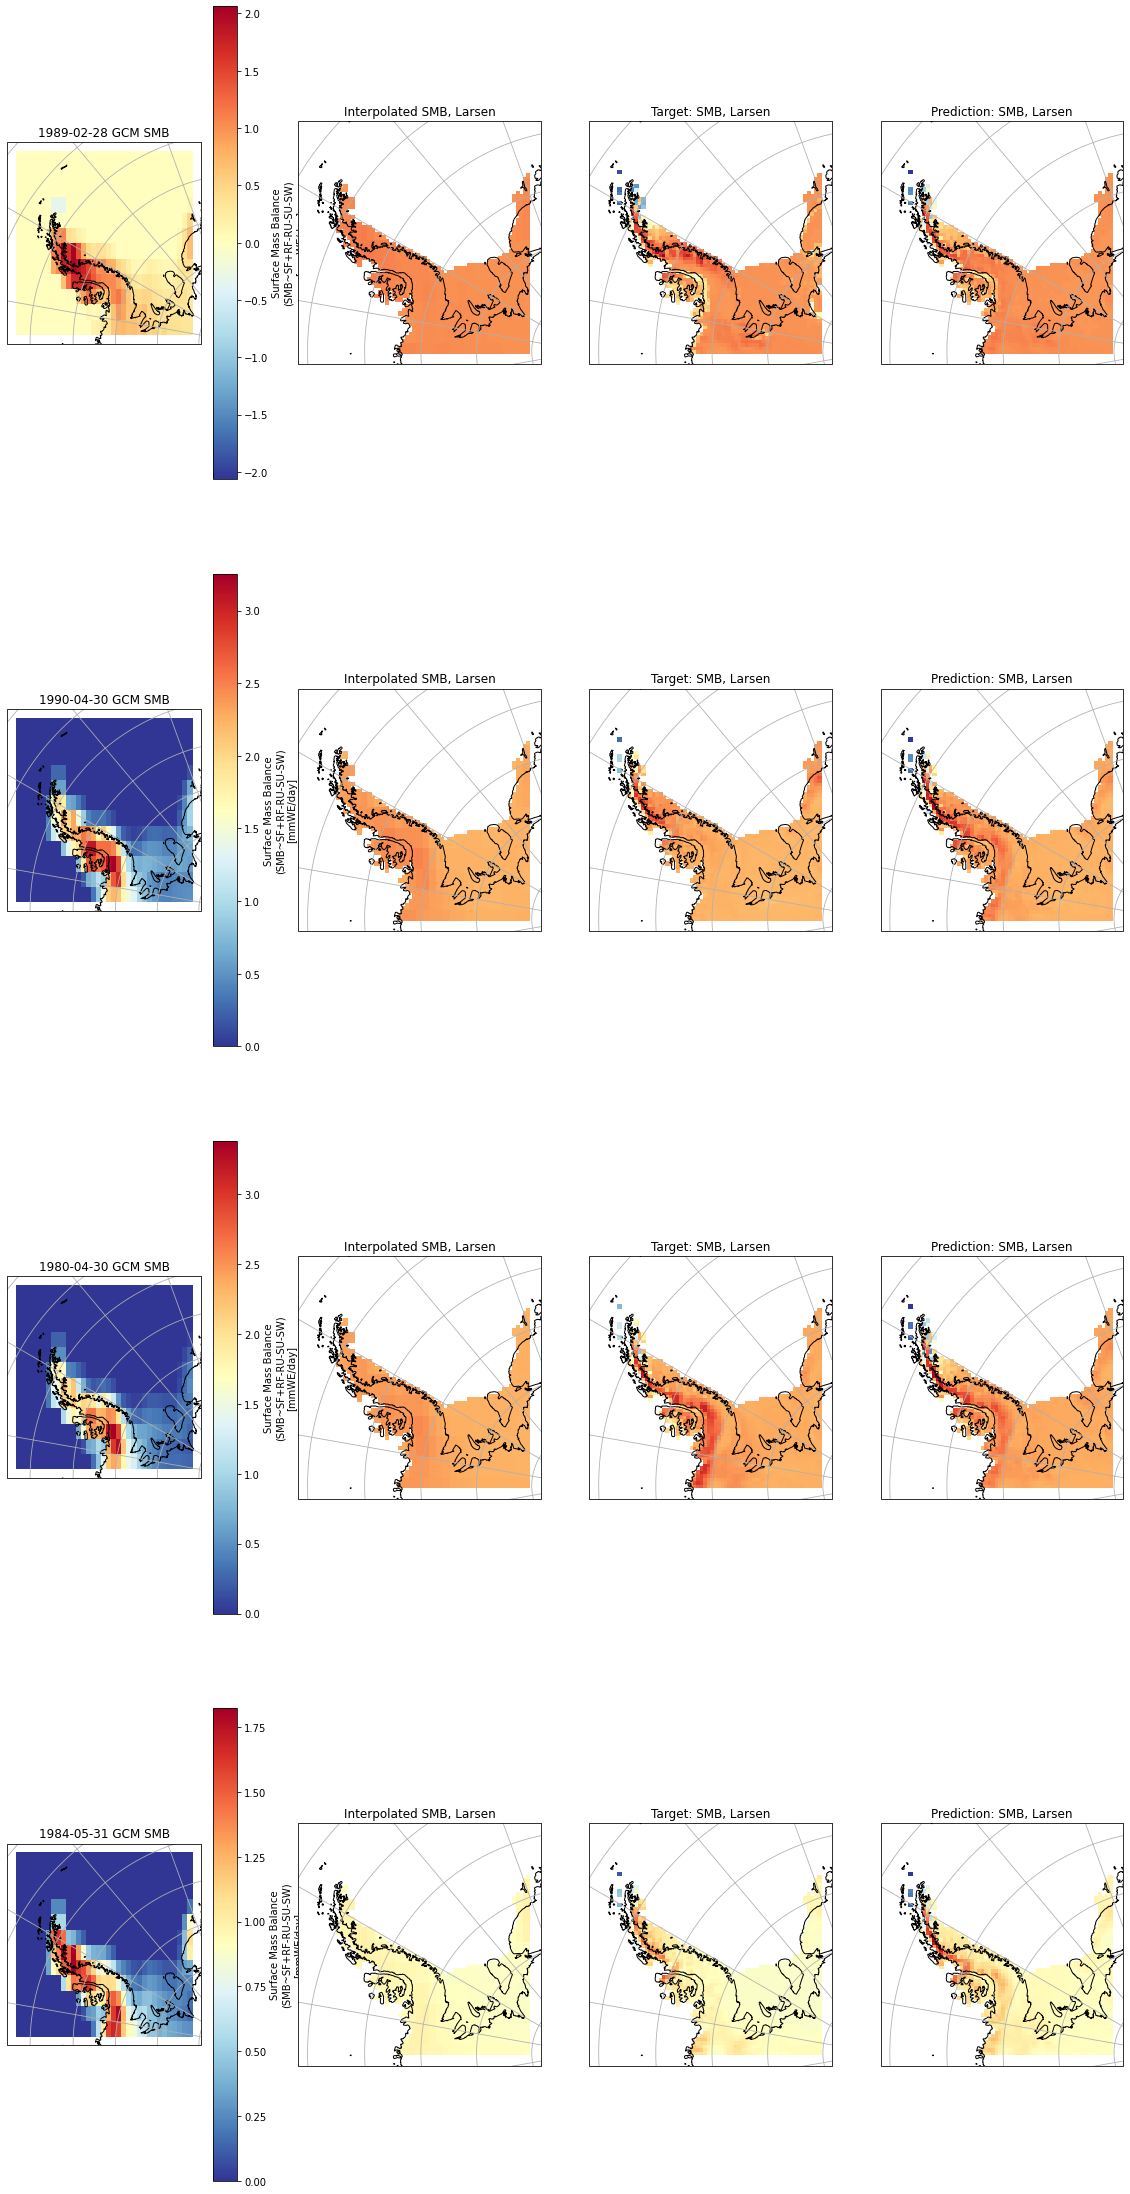

In [35]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Larsen_MSE,
    x_Larsen_MSE,
    z_Larsen_MSE,
    true_smb_Larsen_MSE,
    r_Larsen_MSE,
    GCMLike,
    interp_dataset,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
)
nameFig = "{}_pred_{}_{}_{}.png".format(
    today, REGION, trainingParam["num_epochs"], trainingParam["batch_size"]
)
plt.savefig(nameFig)
# files.download(nameFig)

#### Ridge:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


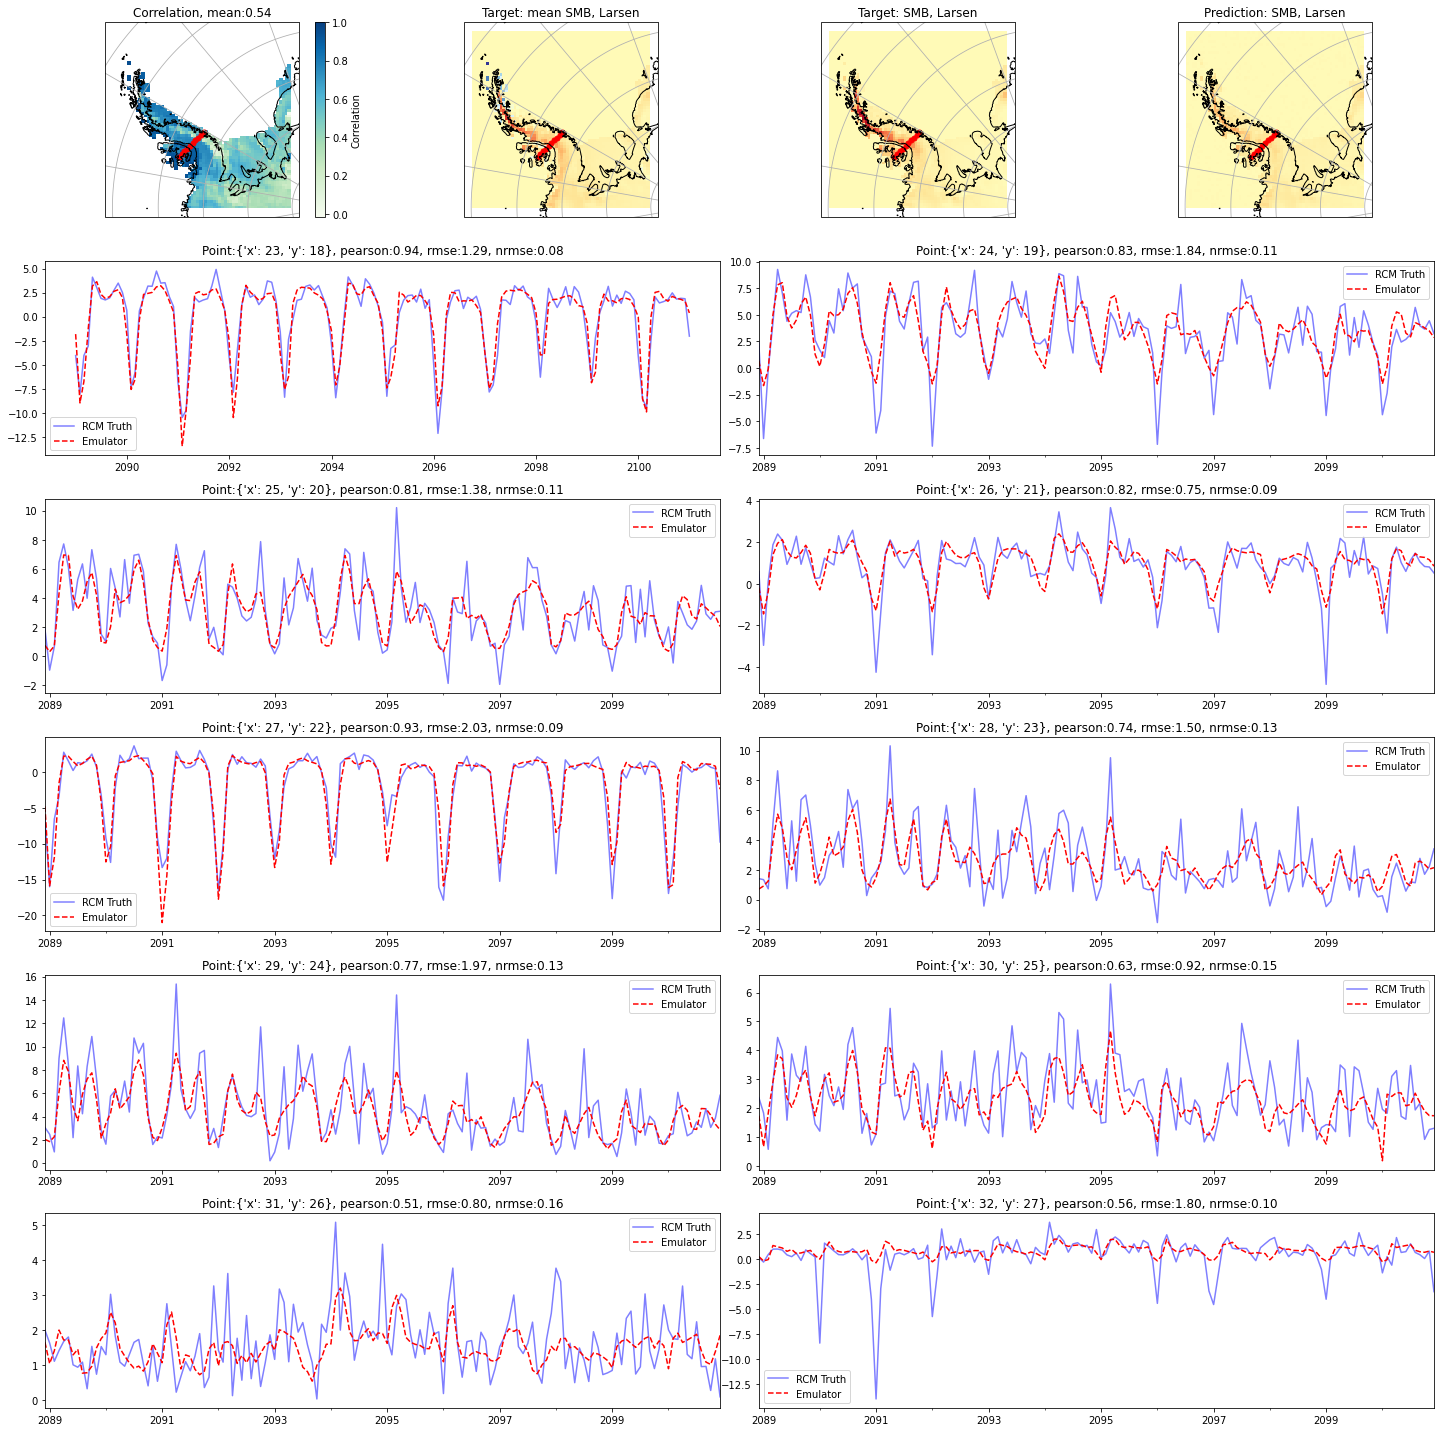

In [36]:
from metrics import *
# plot points
coordinates = (
    {"x": 23, "y": 18},
    {"x": 24, "y": 19},
    {"x": 25, "y": 20},
    {"x": 26, "y": 21},
    {"x": 27, "y": 22},
    {"x": 28, "y": 23},
    {"x": 29, "y": 24},
    {"x": 30, "y": 25},
    {"x": 31, "y": 26},
    {"x": 32, "y": 27}
)

randomPoints(
    coordinates,
    PearsonCorr,
    true_smb_Larsen_MSE,
    preds_Larsen_MSE,
    target_dataset,
    GCMLike,
    train_set,
    REGION,
    N = len(coordinates),
    marker = '.',
    figsize = (20, 20),
)
nameFig = "{}_ts_{}_{}_{}_{}.png".format(
    today, REGION, LOSS_, trainingParam["num_epochs"], trainingParam["batch_size"]
)
#plt.suptitle('Three time series at diffrent coordinates, loss: MSE')
plt.suptitle('')
plt.savefig(nameFig)

#### Time series of GCM:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

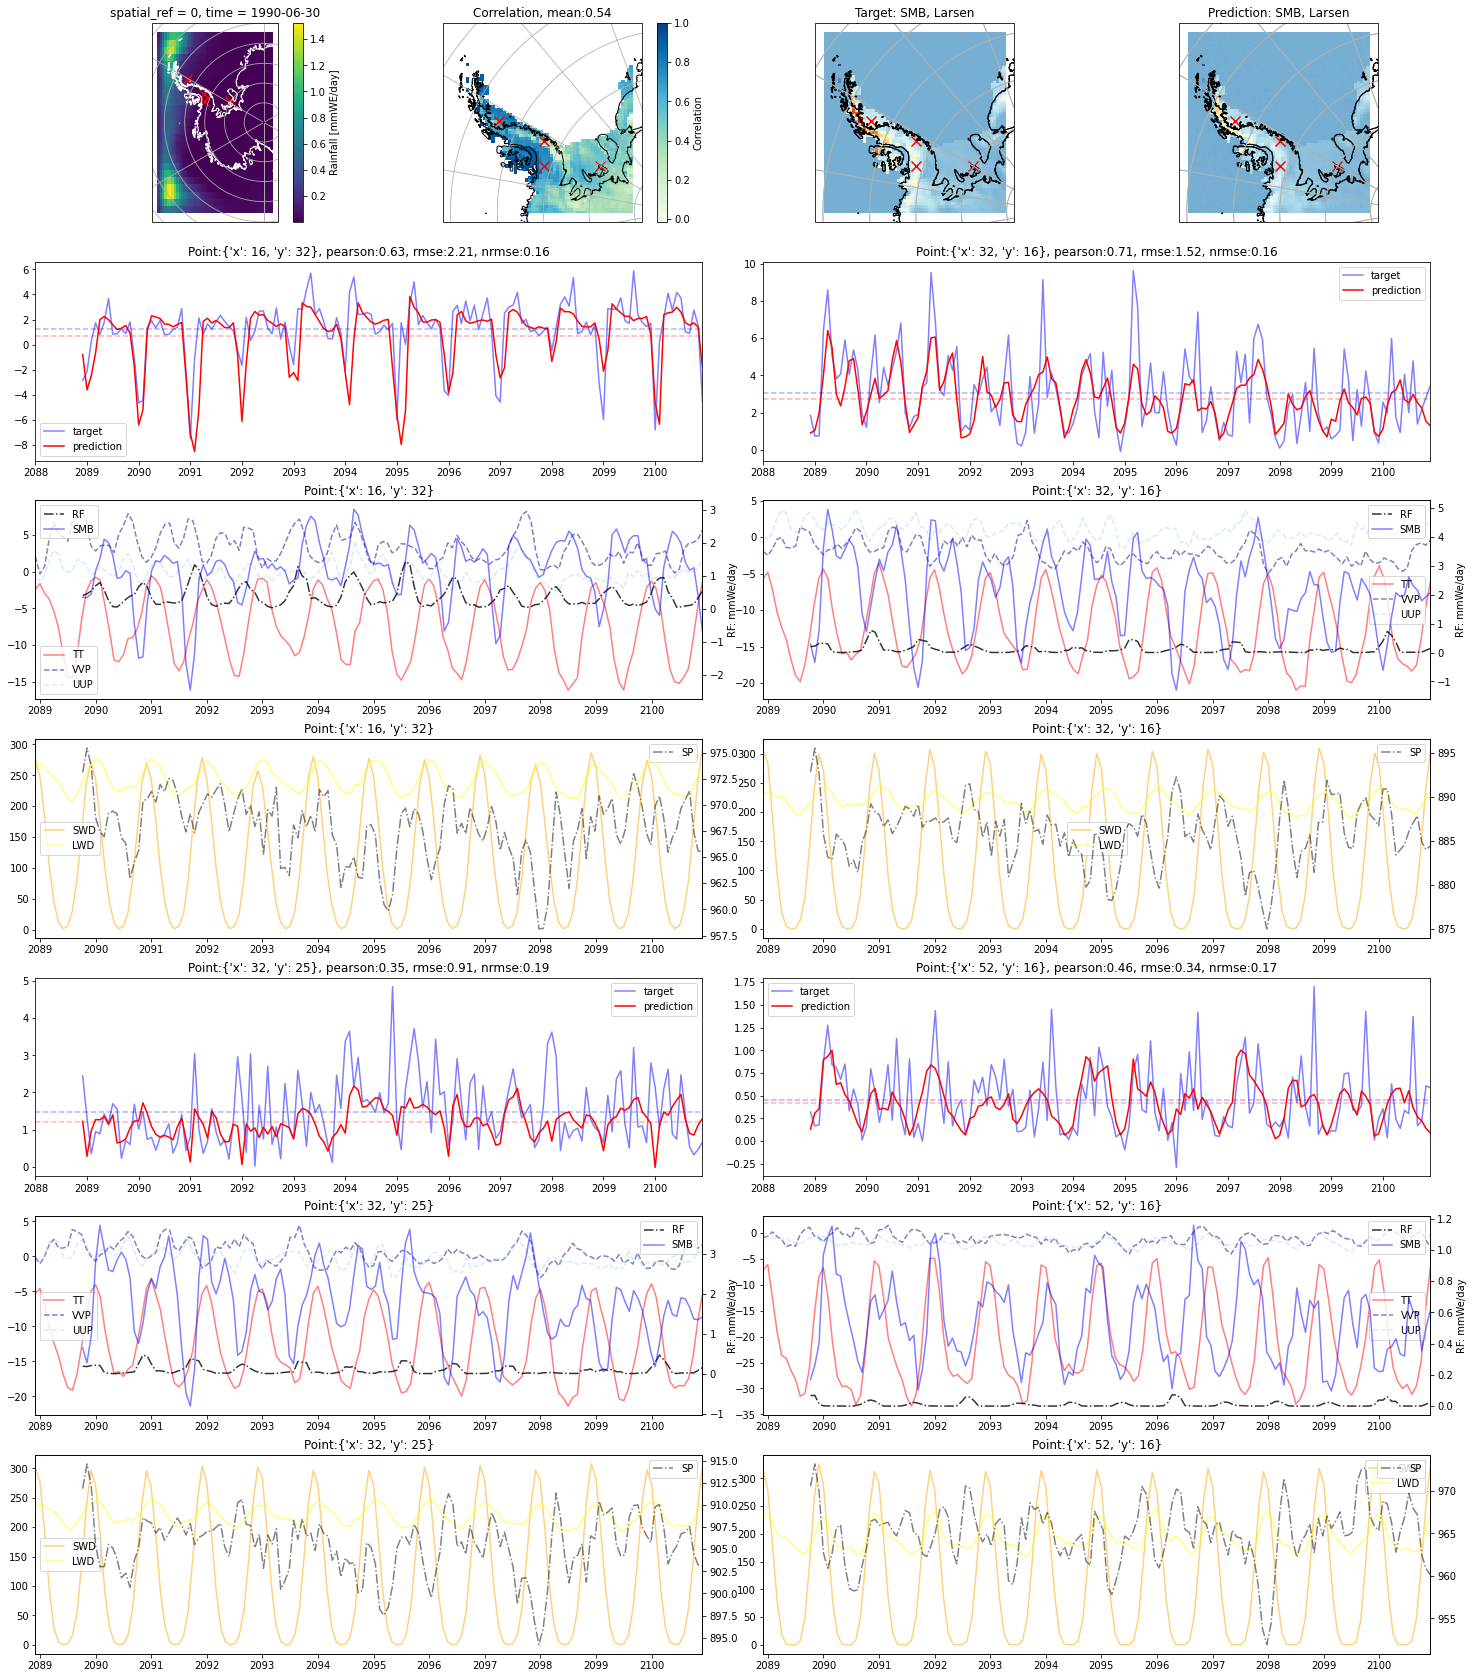

In [37]:
from metrics import *

points_GCM = (
    {"x": 12, "y": 18},
    {"x": 19, "y": 15},
    {"x": 19, "y": 16},
    {"x": 30, "y": 15},
)
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 32, "y": 16},
    {"x": 32, "y": 25},
    {"x": 52, "y": 16},
)
plotGCMTimeseries(
    true_smb_Larsen_MSE,
    preds_Larsen_MSE,
    GCMLike,
    PearsonCorr,
    target_dataset,
    train_set,
    points_GCM,
    points_RCM,
    REGION,
)

## Compare models:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


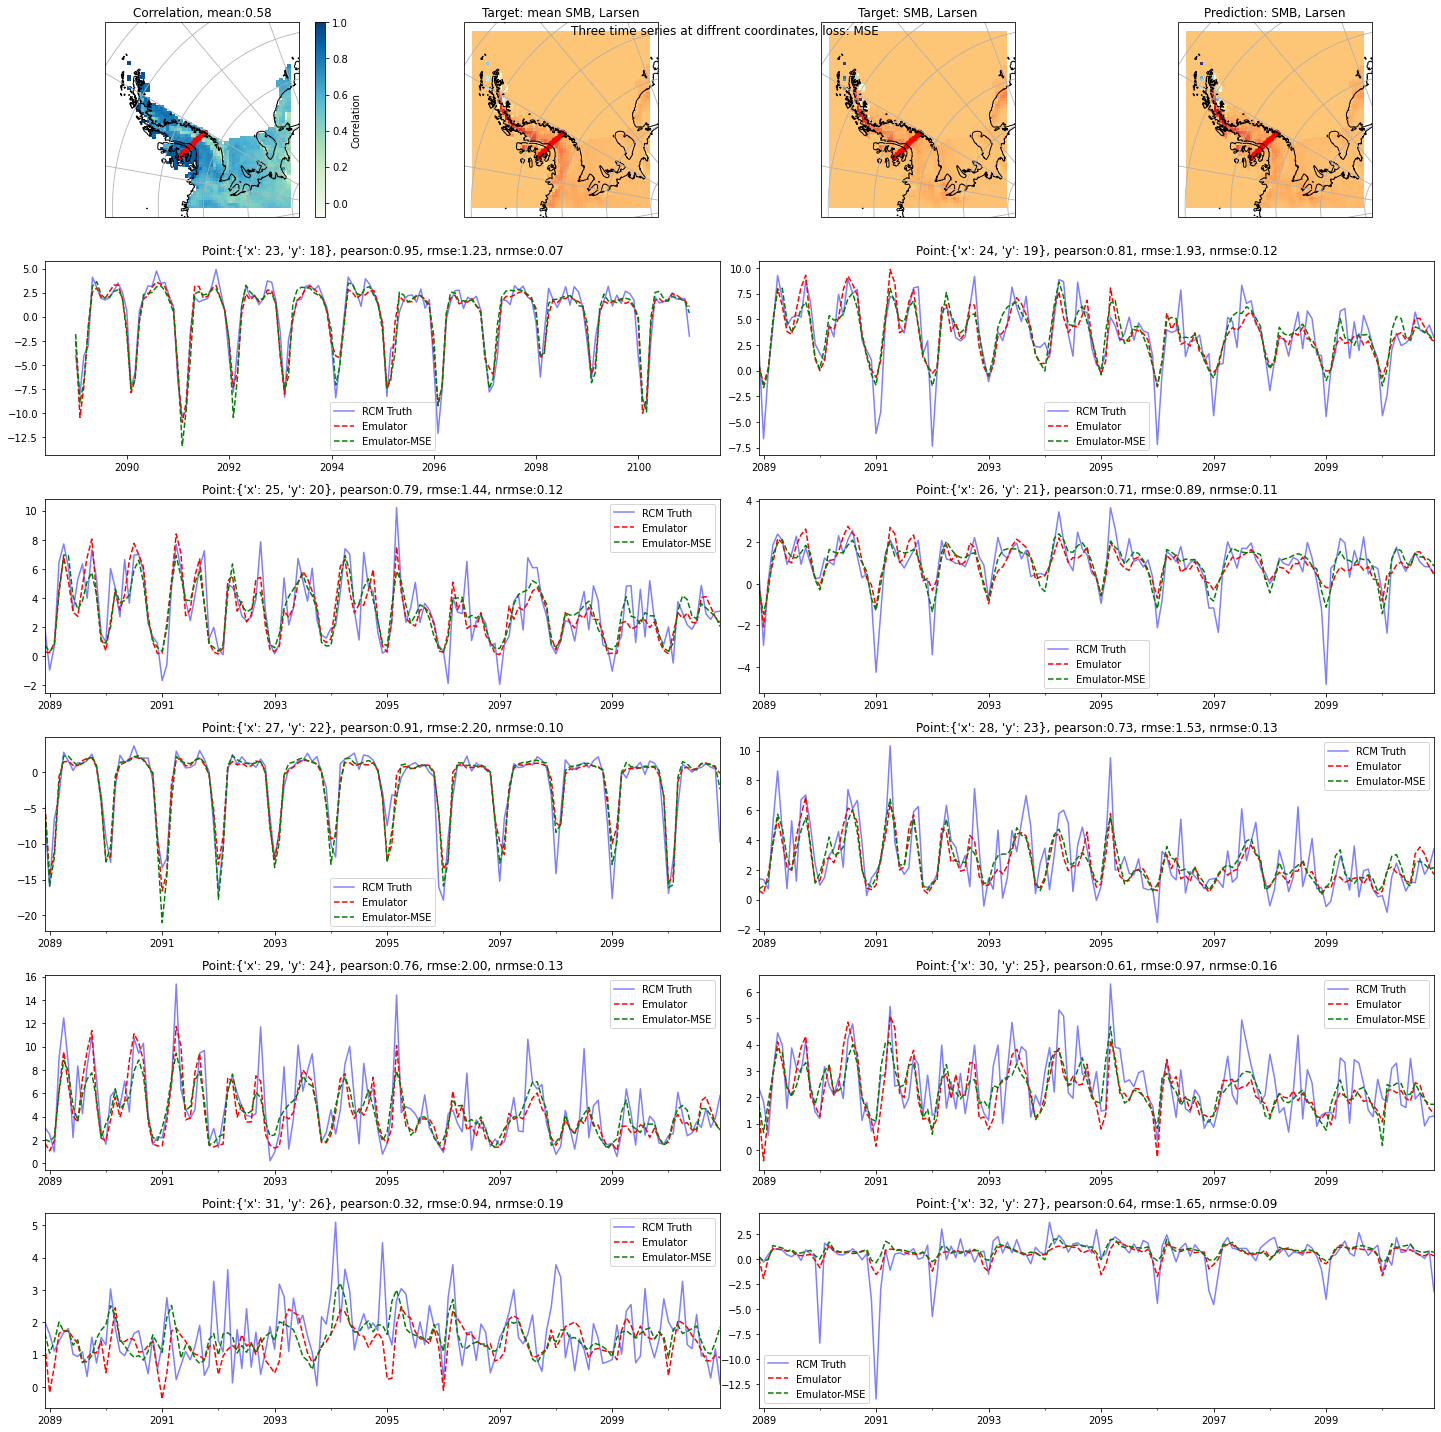

In [47]:
from metrics import *
# plot points
coordinates = (
    {"x": 23, "y": 18},
    {"x": 24, "y": 19},
    {"x": 25, "y": 20},
    {"x": 26, "y": 21},
    {"x": 27, "y": 22},
    {"x": 28, "y": 23},
    {"x": 29, "y": 24},
    {"x": 30, "y": 25},
    {"x": 31, "y": 26},
    {"x": 32, "y": 27}
)

randomPoints(
    coordinates,
    PearsonCorr,
    true_smb_Larsen_NRMSE,
    preds_Larsen_NRMSE,
    target_dataset,
    GCMLike,
    train_set,
    REGION,
    N = len(coordinates),
    marker = '.',
    figsize = (20, 20),
    preds_Larsen_2 = preds_Larsen_MSE
)
nameFig = "{}_ts_{}_{}_{}_{}.png".format(
    today, REGION, LOSS_, trainingParam["num_epochs"], trainingParam["batch_size"]
)
plt.suptitle('Three time series at diffrent coordinates, loss: MSE')
plt.savefig(nameFig)

In [48]:
PearsonCorr_MSE, Wasserstein_MSE, ROV_MSE, MSE_MSE, RMSE_MSE, NRMSE_MSE, PearsonCorrAn_MSE, ROD_MSE = calculateMetrics(
    preds_Larsen_MSE,
    true_smb_Larsen_MSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)

PearsonCorr_NRMSE, Wasserstein_NRMSE, ROV_NRMSE, MSE_NRMSE, RMSE_NRMSE, NRMSE_NRMSE, PearsonCorrAn_NRMSE, ROD_NRMSE = calculateMetrics(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


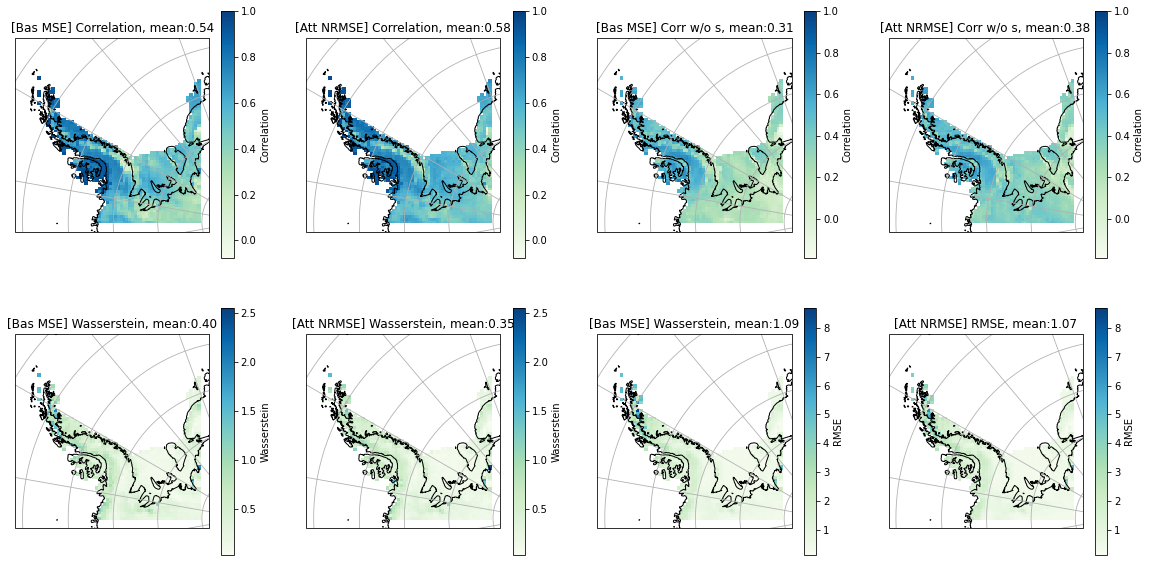

In [52]:
ComparMetrics(
    [PearsonCorr_MSE, PearsonCorr_NRMSE],
    [Wasserstein_MSE, Wasserstein_NRMSE],
    [RMSE_MSE, RMSE_NRMSE],
    [PearsonCorrAn_MSE, PearsonCorrAn_NRMSE], 
    target_dataset,
    region = 'Larsen', models = ['Bas MSE', 'Att NRMSE'])

## Evaluation table:

In [ ]:
PearsonCorr_NRMSE, Wasserstein_NRMSE, ROV_NRMSE, MSE_NRMSE, RMSE_NRMSE, NRMSE_NRMSE, PearsonCorrAn_NRMSE, ROD_NRMSE = calculateMetrics(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)

PearsonCorr_MSE, Wasserstein_MSE, ROV_MSE, MSE_MSE, RMSE_MSE, NRMSE_MSE, PearsonCorrAn_MSE, ROD_MSE = calculateMetrics(
    preds_Larsen_MSE,
    true_smb_Larsen_MSE,
    target_dataset,
    train_set,
    REGION,
    ignoreSea,
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [ ]:
l = [
    metricsData(Wasserstein_MSE),
     metricsData(MSE_MSE),
     metricsData(RMSE_MSE),
    metricsData(NRMSE_MSE),
    metricsData(ROV_MSE),
    metricsData(PearsonCorr_MSE),
     metricsData(PearsonCorrAn_MSE),
     metricsData(ROD_MSE)
]

df_MSE = pd.DataFrame(l, index=["Wasserstein", "MSE","RMSE", "NRMSE", "ROV", "Pearson", "Pearson_An", "ROD"])
df_MSE["Loss"] = ["MSE" for i in range(len(df_MSE))]
df_MSE = df_MSE.reset_index()

In [ ]:
l = [
    metricsData(Wasserstein_NRMSE),
     metricsData(MSE_NRMSE),
     metricsData(RMSE_NRMSE),
    metricsData(NRMSE_NRMSE),
    metricsData(ROV_NRMSE),
    metricsData(PearsonCorr_NRMSE),
     metricsData(PearsonCorrAn_NRMSE),
     metricsData(ROD_NRMSE)
]

df_NRMSE = pd.DataFrame(l, index=["Wasserstein", "MSE","RMSE", "NRMSE", "ROV", "Pearson", "Pearson_An", "ROD"])
df_NRMSE["Loss"] = ["NRMSE" for i in range(len(df_NRMSE))]
df_NRMSE = df_NRMSE.reset_index()

In [ ]:
pd.concat([df_NRMSE, df_MSE]).groupby(['Loss', 'index']).mean()

min       p05       mean     median        p95  \
Loss  index                                                              
MSE   MSE          0.020082  0.108161   1.835828   0.494633   7.300232   
      NRMSE        0.001892  0.004392   0.014036   0.009392   0.036079   
      Pearson      0.039573  0.340815   0.588246   0.569131   0.906298   
      Pearson_An  -0.015339  0.163806   0.371141   0.337504   0.643688   
      RMSE         0.141713  0.328878   1.051083   0.703301   2.701876   
      ROD         -2.000000 -1.740527  -0.103178  -0.031586   1.064128   
      ROV          0.122703  7.410506  45.279063  41.650984  98.197501   
      Wasserstein  0.037153  0.081717   0.340841   0.266551   0.811833   
NRMSE MSE          0.018847  0.118507   1.891621   0.499946   7.487810   
      NRMSE        0.001833  0.004597   0.014331   0.009442   0.036540   
      Pearson      0.058810  0.339575   0.575619   0.545219   0.915615   
      Pearson_An  -0.056923  0.139976   0.356112   0.338013   0.625729   
      RMSE         0.137283  0.344249   1.073218   0.707068   2.736385   
      ROD         -2.000000 -1.631936   0.018404   0.043918   1.491683   
      ROV          0.014672  8.039506  48.720784  46.325547  95.967131   
      Wasserstein  0.037142  0.089294   0.379400   0.261532   1.060810   

                          max  
Loss  index                    
MSE   MSE           45.064953  
      NRMSE          0.089643  
      Pearson        0.971623  
      Pearson_An     0.723036  
      RMSE           6.713044  
      ROD            2.000000  
      ROV          151.549709  
      Wasserstein    2.080045  
NRMSE MSE           40.649338  
      NRMSE          0.085138  
      Pearson        0.974062  
      Pearson_An     0.772979  
      RMSE           6.375683  
      ROD            2.000000  
      ROV          162.514341  
      Wasserstein    2.728697